In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd

from src.data.gamma.structural_arxiv import load_dataset, get_train_val_test_edges, prepare_adjencency, get_edge_index_from_adjencency
from src.train.structural_omega.graph_sage import StructuralOmegaGraphSageCosSim

/home/caiolmartinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-f16XUvnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset_name = 'ogbn-arxiv'

In [4]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename='logs/omega_function/04-1-structural_graphsage_dotmlp_gamma_function.log'
)

In [5]:
torch.cuda.is_available()

True

In [6]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [6]:
dataset = load_dataset()

In [7]:
data, edges_train, edges_val, edges_test = get_train_val_test_edges(dataset, device=device)

In [8]:
data = prepare_adjencency(data)

## Training

In [12]:
for run in range(30):
    for n_layers_graph_sage in range(1, 4):
        omega = StructuralOmegaGraphSageCosSim(
            device,
            dataset='ogbn-arxiv',
            n_layers_graph_sage=n_layers_graph_sage,
            run=run)
        torch.cuda.empty_cache()
        omega.train(edges_train,
                    edges_val,
                    edges_test,
                    data.x,
                    data.y,
                    data.adj_t)

## Results

### For a Layer Number

In [7]:
n_layers_graph_sage = 2

In [8]:
metrics = StructuralOmegaGraphSageCosSim.read_metrics(
    n_layers_graph_sage=n_layers_graph_sage,
    dataset='ogbn-arxiv')
print(metrics.shape)
metrics.head()

(1530, 8)


,run,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,0,0,0.625161,0.649909,0.653825,0.527779,0.515756,0.513577
1,0,100,0.524813,0.547140,0.564427,0.791742,0.785564,0.762209
2,0,200,0.493942,0.529257,0.561997,0.817979,0.797482,0.758800
3,0,300,0.473229,0.514151,0.542827,0.834575,0.809428,0.780331
4,0,400,0.457455,0.503561,0.540531,0.844189,0.815669,0.781216


### Sumarize metrics per epoch

In [9]:
metrics_cols = metrics.columns[2:]
metrics_cols

Index(['loss_train', 'loss_val', 'loss_test', 'auc_train', 'auc_val',
       'auc_test'],
      dtype='object')

In [10]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [11]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
0,0.625363,0.000705,0.649860,0.000401,0.653788,0.000499,0.524962,0.005285,0.517842,0.004404,0.517238,0.004608
100,0.523150,0.002194,0.546422,0.002345,0.565439,0.002150,0.794617,0.003330,0.787014,0.003464,0.759273,0.003022
200,0.490008,0.004885,0.523616,0.004889,0.549335,0.005458,0.822028,0.004969,0.801923,0.004247,0.772083,0.005262
300,0.472645,0.005571,0.512364,0.005198,0.541376,0.005686,0.833956,0.004935,0.809021,0.004465,0.779223,0.004685
400,0.459399,0.005289,0.506074,0.003477,0.537518,0.003751,0.842569,0.004870,0.813276,0.003155,0.783153,0.003057


In [12]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
3900,0.402124,0.007120,0.506933,0.003960,0.555850,0.005133,0.878974,0.004589,0.825325,0.002889,0.791942,0.003329
4100,0.401422,0.005022,0.506828,0.003614,0.556223,0.004033,0.879458,0.003211,0.825300,0.002477,0.791860,0.002505
3300,0.404995,0.005757,0.505706,0.003651,0.553688,0.004828,0.877082,0.003767,0.825251,0.003061,0.792224,0.002613
4600,0.400385,0.005621,0.507431,0.004152,0.556720,0.005636,0.880044,0.003535,0.825153,0.002703,0.791591,0.003512
4400,0.401111,0.005218,0.507201,0.002562,0.556428,0.004640,0.879612,0.003291,0.825144,0.001916,0.791852,0.002286


/tmp/ipykernel_36451/4070240928.py:8: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_36451/4070240928.py:9: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.

/tmp/ipykernel_36451/4070240928.py:56: FutureWarning:

The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavio

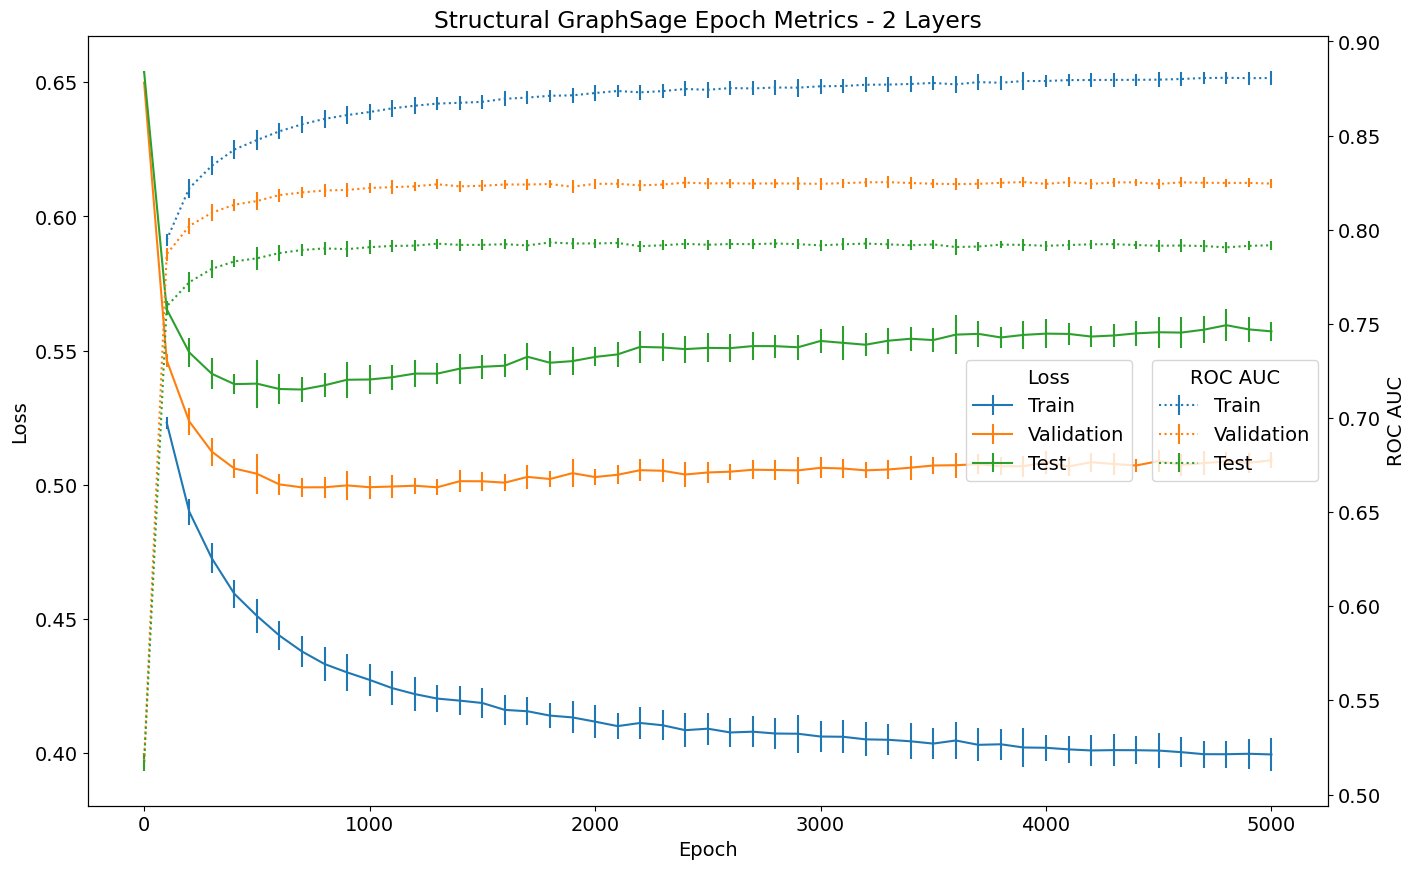

In [13]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title(f'Structural GraphSage Epoch Metrics - {n_layers_graph_sage} Layers')

ax1.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

# ax1.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['loss_train_mean'][1:],
#     # yerr=epoch_metrics['loss_train_std'][1:],
#     ls='-',
#     label='Train')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_val_mean'],
#     # yerr=epoch_metrics['loss_val_std'],
#     ls='-',
#     label='Validation')

# ax1.plot(
#     epoch_metrics.index,
#     epoch_metrics['loss_test_mean'],
#     # yerr=epoch_metrics['loss_test_std'],
#     ls='-',
#     label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

ax2.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

# ax2.plot(
#     epoch_metrics.index[1:],
#     epoch_metrics['auc_train_mean'][1:],
#     # yerr=epoch_metrics['auc_train_std'][1:],
#     ls=':',
#     label='Train')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_val_mean'],
#     # yerr=epoch_metrics['auc_val_std'],
#     ls=':',
#     label='Validation')

# ax2.plot(
#     epoch_metrics.index,
#     epoch_metrics['auc_test_mean'],
#     # yerr=epoch_metrics['auc_test_std'],
#     ls=':',
#     label='Test')

ax2.legend(loc='center right', title='ROC AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC AUC')

plt.savefig(f'reports/images/structural_omega_graphsage_cossim_training_metrics_{n_layers_graph_sage}gslayers.pdf')

### Comparing Validation Performance for All Layer numbers

In [14]:
n_layers_list = range(1, 4)

In [17]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}
for n_layers_graph_sage in n_layers_list:
    metrics = StructuralOmegaGraphSageCosSim.read_metrics(
        dataset=dataset_name,
        n_layers_graph_sage=n_layers_graph_sage
    )
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[n_layers_graph_sage] = auc_val
    mean_loss_val_dict[n_layers_graph_sage] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[n_layers_graph_sage] = auc_val
    std_loss_val_dict[n_layers_graph_sage] = loss_val

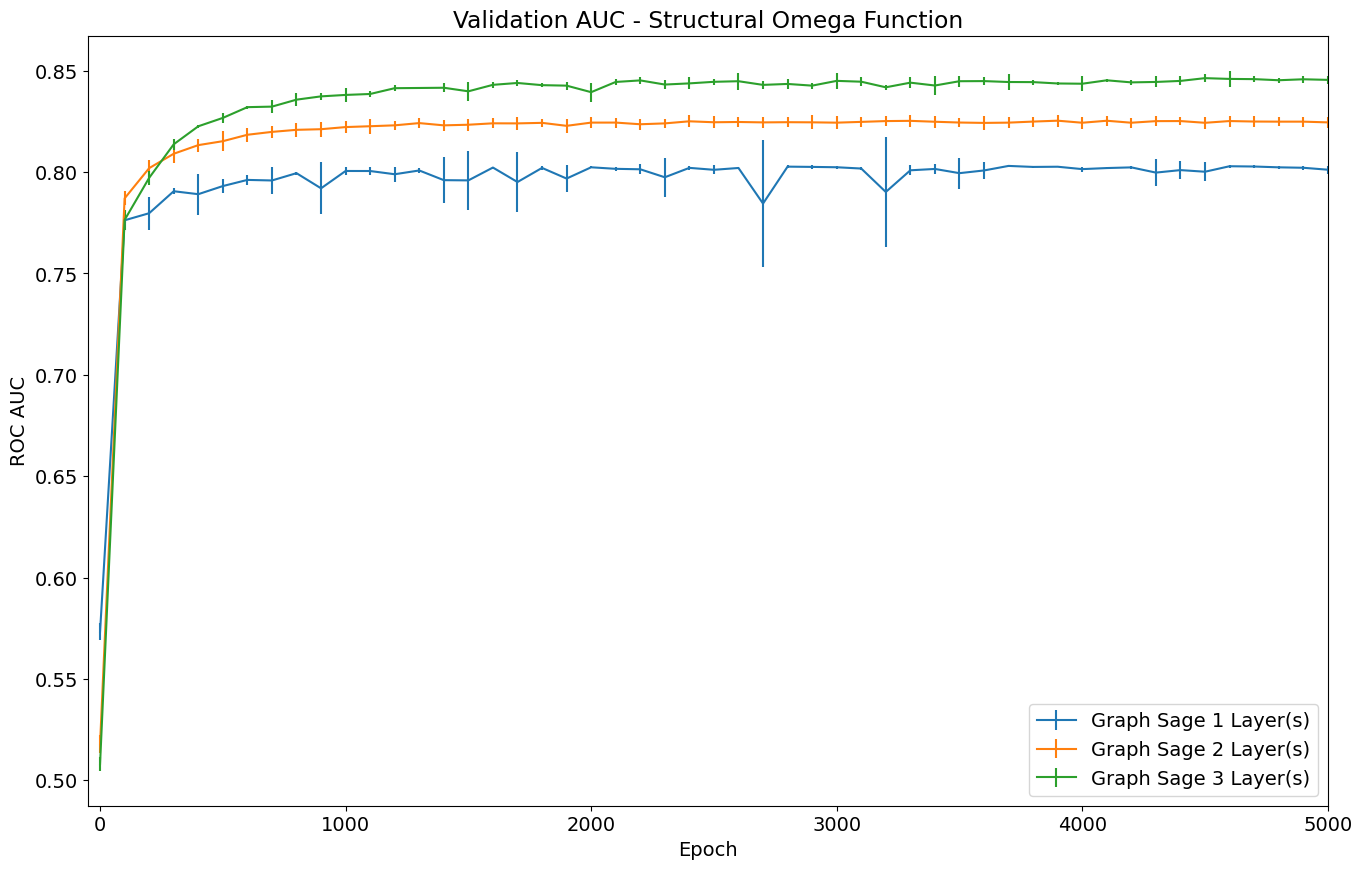

In [18]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation AUC - Structural Omega Function')

for n_layers in mean_auc_val_dict:
    ax1.errorbar(
        mean_auc_val_dict[n_layers].index,
        mean_auc_val_dict[n_layers],
        yerr=std_auc_val_dict[n_layers],
        ls='-',
        label=f'Graph Sage {n_layers} Layer(s)')

ax1.set_xlim(-50, 5000)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('ROC AUC')

ax1.legend()

## Score Best model

In [19]:
best_model_metrics = metrics.sort_values('auc_val', ascending=False).iloc[0]
best_model_metrics

run              4.000000
epoch         4600.000000
loss_train       0.382392
loss_val         0.465065
loss_test        0.515976
auc_train        0.889903
auc_val          0.851588
auc_test         0.818473
Name: 250, dtype: float64

In [27]:
os.listdir(f'models/structural_omega_grapn_sage_cossim')

['pubmed', 'cora', 'best_model_info.json', 'ogbn-arxiv', 'citeseer']

In [28]:
best_model_metrics.to_json(f'models/structural_omega_grapn_sage_cossim/{dataset_name}/best_model_info.json')

### Load data

In [30]:
dataset = load_dataset()

data, edges_train, edges_val, edges_test = get_train_val_test_edges(
    dataset=dataset, device=device
)

data = prepare_adjencency(data, to_symmetric=True)

edge_index = get_edge_index_from_adjencency(data, device)

### Load model

In [31]:
data.num_nodes

169343

In [36]:
omega = StructuralOmegaGraphSageCosSim.load_model(
    dataset=dataset_name,
    run=int(best_model_metrics['run']),
    epoch=int(best_model_metrics['epoch']),
    device=device,
    n_layers_graph_sage=3,
    batch_size=1024)

In [37]:
dataset

PygNodePropPredDataset()

### Score model

In [38]:
dataset = load_dataset()
data = prepare_adjencency(dataset[0], to_symmetric=True).to(device)

edge_index = get_edge_index_from_adjencency(data, device)

In [39]:
edge_index

tensor([[   411,    640,   1162,  ..., 163274,  27824, 158981],
        [     0,      0,      0,  ..., 169341, 169342, 169342]],
       device='cuda:0')

In [40]:
edges_train

tensor([[104447,  15858, 107156,  ...,   1326, 129609,  26457],
        [ 13091,  47283,  69161,  ...,  55379, 158430,  54167]],
       device='cuda:0')

In [42]:
preds_train = omega.forward(edges_train, data.x, data.adj_t).to('cpu').detach().numpy()
preds_train[:5]

array([[0.39369652],
       [0.11731733],
       [0.46927968],
       [0.12220458],
       [0.04423578]], dtype=float32)

In [43]:
preds_val = omega.forward(edges_val, data.x, data.adj_t).to('cpu').detach().numpy()
preds_val[:5]

array([[0.9460168 ],
       [0.83816004],
       [0.8740781 ],
       [0.35600442],
       [0.6821827 ]], dtype=float32)

In [44]:
preds_test = omega.forward(edges_test, data.x, data.adj_t).to('cpu').detach().numpy()
preds_test[:5]

array([[0.889694  ],
       [0.73500896],
       [0.834004  ],
       [0.58543926],
       [0.7033087 ]], dtype=float32)

In [45]:
preds = np.concatenate([preds_train, preds_val, preds_test])

In [46]:
edges = torch.concat([edges_train, edges_val, edges_test], dim=1)
edges

tensor([[104447,  15858, 107156,  ...,  45118,  45118,  45118],
        [ 13091,  47283,  69161,  ..., 162473, 162537,  72717]],
       device='cuda:0')

In [47]:
theta = omega.is_same_class(edges, data.y).to('cpu').detach().numpy()

In [48]:
roc_auc_score(theta, preds)

0.8699908991623656

In [49]:
theta.mean()

0.655083031580897

### Save output

In [50]:
cpu_edges = edges.to('cpu').numpy()
edges_omega_df = pd.DataFrame({
    'source': cpu_edges[0],
    'target': cpu_edges[1],
    'omega_pred': preds[:,0]
})
print(edges_omega_df.shape)
edges_omega_df.head()

(1166243, 3)


,source,target,omega_pred
0,104447,13091,0.393697
1,15858,47283,0.117317
2,107156,69161,0.469280
3,107156,136440,0.122205
4,107156,107366,0.044236


In [51]:
edges_omega_df.to_csv(f'data/scored_omega/{dataset_name}/structural_omega_graph_sage_cossim.csv', index=False)

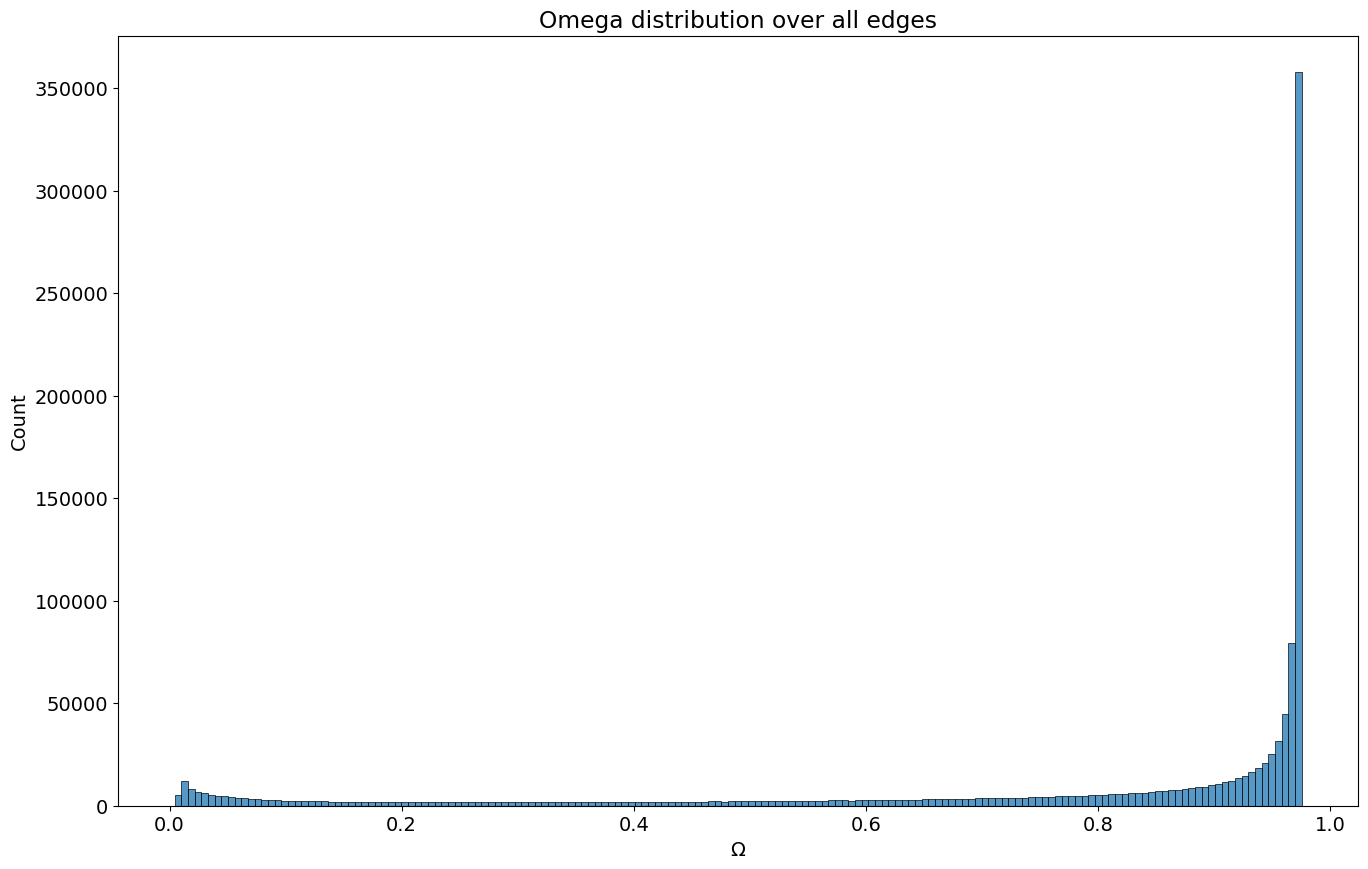

In [53]:
plt.rcParams['font.size'] = '14'
plt.figure(figsize=(16, 10))

sns.histplot(
    edges_omega_df['omega_pred'])

plt.xlabel('$\Omega$')
plt.title('Omega distribution over all edges')
plt.savefig(f'reports/images/{dataset_name}/structural_omega_graph_sage_cossim/best_omega_distribution.png')

In [54]:
metrics = {
    'ROC AUC - All edges': [roc_auc_score(theta, preds)],
    'Mean': [edges_omega_df['omega_pred'].mean()],
    'Std. Dev.': [edges_omega_df['omega_pred'].std()],
    'Skewness': [edges_omega_df['omega_pred'].skew()],
    'Kurtosis': [edges_omega_df['omega_pred'].kurt()],
}

print(pd.DataFrame(metrics).round(3).style.to_latex())

\begin{tabular}{lrrrrr}
 & ROC AUC - All edges & Mean & Std. Dev. & Skewness & Kurtosis \\
0 & 0.870000 & 0.769000 & 0.297000 & -1.420000 & 0.642000 \\
\end{tabular}

